### Preamble

In [219]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from fmnist import testset, LeNet5
from tqdm import tqdm
from style import bold, plot_accuracies, print_preds_memory
from style import print_table_1, print_table_2, print_table_3
from style import plot_figure_3a
from metrics import compute_preds, compute_accuracies, compute_disagreement
from metrics import compute_ensemble_predictions, compute_abstention_rate
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load models, data, predictions

In [2]:
# Sources of randomness are random state (RS) initialization and leave-one-out (LOO)
# We have modified LOO for these experiments to leave out 10% of the training data (60k -> 54k inputs)
random_sources = ['rs', 'loo']
n_models = 200

In [3]:
test = DataLoader(testset, batch_size=len(testset), shuffle=False)
test = next(iter(test))
X_test, y_test = test[0].numpy(), test[1].numpy()
n_inputs = X_test.shape[0]

In [4]:
gs = []
for random_source in random_sources:
    g = []  # list of models (g is paper convention)
    for i in range(n_models):
        model = LeNet5(10, 0.1)
        model.load_state_dict(torch.load(f'checkpoints/{random_source}_model{i}.pth'))
        g.append(model)
    gs.append(g)

In [6]:
preds = []  # append 2 numpy arrays of size 200x10000
for i, g in enumerate(gs):
    # ~40 seconds to compute 10,000 predictions x 200 models
    print(bold(f'Source of Randomness: {random_sources[i].upper()}'))
    preds.append(compute_preds(g, X_test, return_numpy=True))
    print_preds_memory(preds[i])
    if i==0:
        print("\n")

Source of Randomness: RS


100%|██████████| 200/200 [00:39<00:00,  5.02it/s]


200 models, 10000 test inputs
40KB memory (single model predictions)
8MB memory (all model predictions)


Source of Randomness: LOO


100%|██████████| 200/200 [00:39<00:00,  5.01it/s]

200 models, 10000 test inputs
40KB memory (single model predictions)
8MB memory (all model predictions)


### Table 1: Singleton model accuracy (FMNIST)

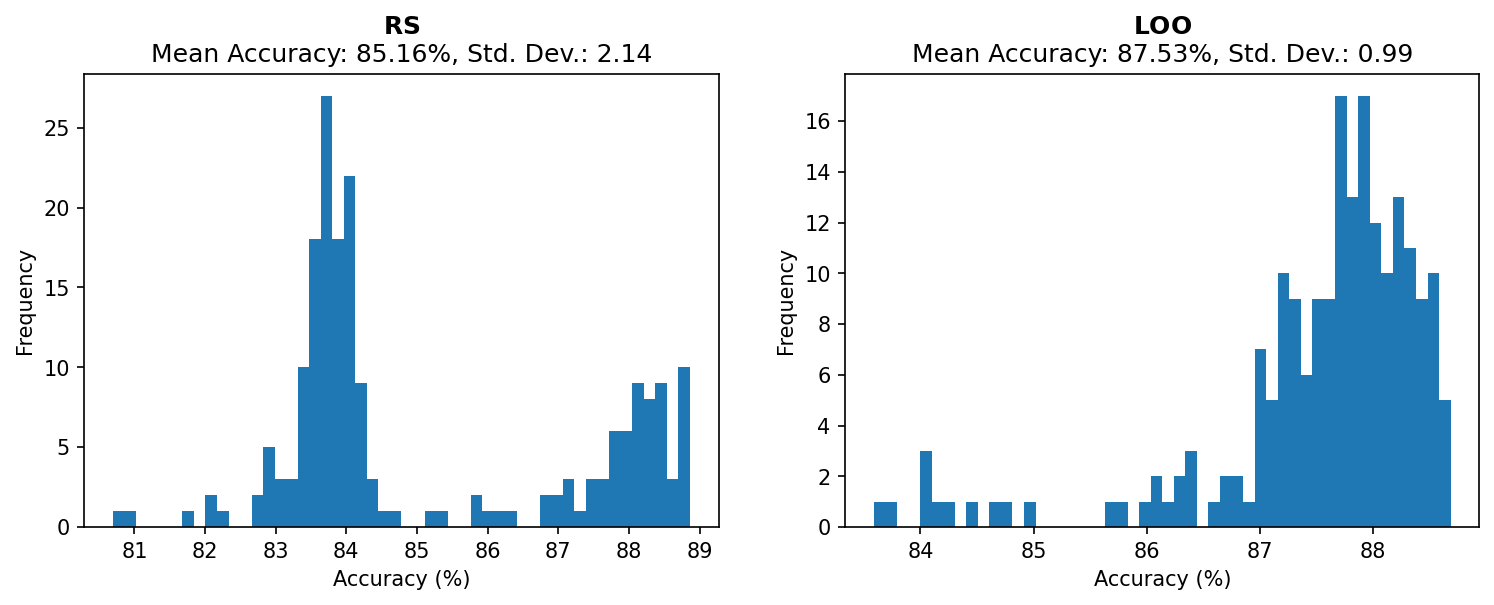

In [7]:
accs = []  # append 2 numpy arrays of size 200
for i, random_source in enumerate(random_sources):
    accs.append(compute_accuracies(preds[i], y_test))
plot_accuracies(accs, random_sources)

In [8]:
print_table_1(accs, random_sources)

Randomness		FMNIST
----------------------------------------
RS			85.16±2.14
----------------------------------------
LOO			87.53±0.99
----------------------------------------

Table 1: Mean accuracy over 200 models
trained over changes to random initialization
and leave-one-out differences in training data.


### Table 2: Proportion of points with disagreement

##### Compare Singleton Models

In [112]:
# For one input, if any two predictions differ (across all models), disagreement = 1
# Computes proportion of inputs with disagreement = 1
# pred is size (no. models x no.inputs)
disagreements_full = [compute_disagreement(pred) for pred in preds]

##### Construct and Compare Selective Ensembles

In [113]:
n_ensembles_per_comparison = 10  # number of ensembles to compare
ensemble_sizes = [5, 10, 15, 20]  # number of models per ensemble
selective_disagreements = np.zeros((len(random_sources), len(ensemble_sizes)))
traditional_disagreements = np.zeros((len(random_sources), len(ensemble_sizes)))

In [114]:
# Compute these statistics for Table 3 (next section)
shape = [len(random_sources), len(ensemble_sizes), n_ensembles_per_comparison]
selective_accs = np.zeros(shape)  # accuracies of selective ensembles
abstention_rates = np.zeros(shape)  # abstention rates of selective ensembles
traditional_accs = np.zeros(shape)  # accuracies of traditional ensemble

In [115]:
# For each source of randomness
for i, random_source in enumerate(random_sources):
    print(bold(f'Source of Randomness: {random_source.upper()}'))

    # For each different ensemble size (5, 10, 15, 20)
    for j, ensemble_size in enumerate(tqdm(ensemble_sizes)):

        # Size of preds is no. ensembles x no. inputs
        args = [ensemble_size, n_ensembles_per_comparison, preds[i], 'selective']
        selective_ensemble_preds = compute_ensemble_predictions(*args)

        # Accuracy and abstention
        selective_accs[i,j] = compute_accuracies(selective_ensemble_preds, y_test)
        abstention_rates[i,j] = compute_abstention_rate(selective_ensemble_preds)
        
        # Traditional majority voting
        args = [ensemble_size, n_ensembles_per_comparison, preds[i], 'majority']
        traditional_ensemble_preds = compute_ensemble_predictions(*args)
        traditional_accs[i,j] = compute_accuracies(traditional_ensemble_preds, y_test)
        
        # Disagreement between selective ensembles (scalar)
        selective_disagreements[i,j] = compute_disagreement(selective_ensemble_preds)
        
        # Disagreement between traditional ensembles (scalar)
        traditional_disagreements[i,j] = compute_disagreement(traditional_ensemble_preds)

Source of Randomness: RS


100%|██████████| 4/4 [00:15<00:00,  3.85s/it]


Source of Randomness: LOO


100%|██████████| 4/4 [00:14<00:00,  3.65s/it]


In [116]:
# Not included in paper
# Since we compare 10 selective ensembles
# It seems more fair to compare 10 singleton models sampled from the set of 200
# Rather than computing disagreement between 200 models 
trials = n_models//n_ensembles_per_comparison
disagreements_partial = np.zeros((len(random_sources), trials))
for i in range(len(random_sources)):
    for j in range(trials):
        lower = j*n_ensembles_per_comparison
        upper = (j+1)*n_ensembles_per_comparison
        disagreements_partial[i,j] = compute_disagreement(preds[i][lower:upper])

##### Print Table 2 (FMNIST)

In [117]:
print_table_2(disagreements_full, disagreements_partial,
              selective_disagreements, ensemble_sizes, random_sources)

Randomness		n			FMNIST
------------------------------------------------------------
RS			1 (full)		0.4564
RS			1 (partial)		0.2368
RS			5			0.2784
RS			10			0.172
RS			15			0.1431
RS			20			0.141
------------------------------------------------------------
LOO			1 (full)		0.3982
LOO			1 (partial)		0.2146
LOO			5			0.2771
LOO			10			0.1646
LOO			15			0.1354
LOO			20			0.1123
------------------------------------------------------------
Table 2: Percentage of points with disagreement
between at least one pair of models (p_flip>0)
trained with different random seeds (RS) or leave-
one-out (LOO) differences in training data for
singleton models (n=1) and selective ensembles (n>1).
All 200 models are used in the (full) comparison, while
10 models or ensembles are used in the remaining rows.


### Table 3: Selective vs Traditional Ensemble Comparison

In [215]:
print_table_3(selective_accs, abstention_rates,
              traditional_accs, ensemble_sizes, random_sources)

accuracy (abstain as error) | abstention rate | non-selective accuracy
Randomness		n		    FMNIST
------------------------------------------------------------
RS			5		76.1|19.7|86.9
RS			10		80.9|11.6|86.5
RS			15		82.0|9.71|85.8
RS			20		82.6|7.74|85.8
------------------------------------------------------------
LOO			5		79.5|15.8|88.8
LOO			10		84.1|9.43|89.0
LOO			15		85.3|7.48|89.2
LOO			20		86.1|6.29|89.2
------------------------------------------------------------
Table 3: Accuracy and abstention rate of selective ensembles,
along with the accuracy of non-selective (traditional ensembles)
with n ∈ {5,10,15,20} constituents. Results are averaged over 10
randomly selected models.


### Figure 3a: Selective vs Traditional Ensemble Disagreement

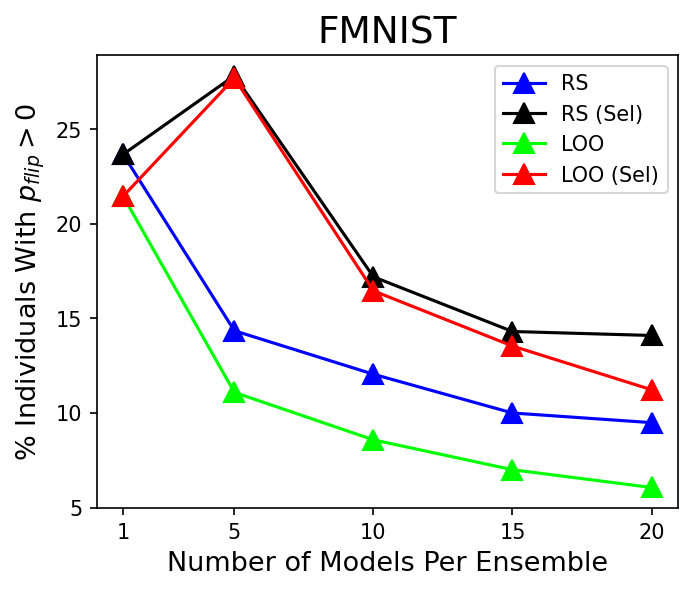

In [220]:
plot_figure_3a(disagreements_partial, traditional_disagreements,
               selective_disagreements, ensemble_sizes, random_sources)

### Figure 3b: Selective vs Traditional Ensemble Feature Attributions

In [221]:
model

LeNet5(
  (layer1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (softmax): Softmax(dim=-1)
)